In [339]:
import torch
import torch.nn as nn #related to neural networks
import torch.optim as optim #optimizer
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys
import PIL
import timm
import tqdm

In [340]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [341]:
import yaml
def get_labels(yaml_file_path):
    with open(yaml_file_path, "r") as file:
        yaml_content = yaml.safe_load(file)
    return yaml_content.get("names", [])

# Create Circuit Diagram Dataset

In [342]:
class CircuitDiagramDataset(Dataset):
    def __init__(self, root, transform=None):
        self.annotations_dir = os.path.join(root, "labels")
        self.annotations = list(sorted(os.listdir(self.annotations_dir)))
        self.image_dir = os.path.join(root, "images")
        self.images = list(sorted(os.listdir(self.image_dir)))
        self.transform = transform
        self.labels = get_labels("./yolo_dataset/data.yaml")
        

    
    def __len__(self):
        return len(os.listdir(self.image_dir))
    
    def __getitem__(self, idx):
        image = PIL.Image.open(os.path.join(self.image_dir, self.images[idx]))
        if self.transform:
            image = self.transform(image)
        with open(os.path.join(self.annotations_dir, self.annotations[idx])) as f:
            annotation = f.readlines()
            annotation = [x.strip() for x in annotation]
        return image, annotation
    

In [343]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test = CircuitDiagramDataset(    
    root='yolo_dataset/train',
    transform=transform)

print(test.annotations)
print(test.images)   

['1.txt', '10.txt', '100.txt', '101.txt', '102.txt', '103.txt', '104.txt', '105.txt', '106.txt', '107.txt', '108.txt', '109.txt', '11.txt', '110.txt', '111.txt', '112.txt', '113.txt', '114.txt', '115.txt', '116.txt', '117.txt', '118.txt', '119.txt', '12.txt', '120.txt', '121.txt', '122.txt', '123.txt', '124.txt', '125.txt', '126.txt', '127.txt', '128.txt', '129.txt', '13.txt', '130.txt', '131.txt', '132.txt', '133.txt', '134.txt', '135.txt', '136.txt', '137.txt', '138.txt', '139.txt', '14.txt', '140.txt', '141.txt', '142.txt', '143.txt', '144.txt', '145.txt', '146.txt', '147.txt', '148.txt', '149.txt', '15.txt', '150.txt', '151.txt', '152.txt', '153.txt', '154.txt', '155.txt', '156.txt', '157.txt', '158.txt', '159.txt', '16.txt', '160.txt', '17.txt', '18.txt', '19.txt', '2.txt', '20.txt', '21.txt', '22.txt', '23.txt', '24.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '3.txt', '30.txt', '31.txt', '32.txt', '33.txt', '34.txt', '35.txt', '36.txt', '37.txt', '38.txt', '39.txt', '

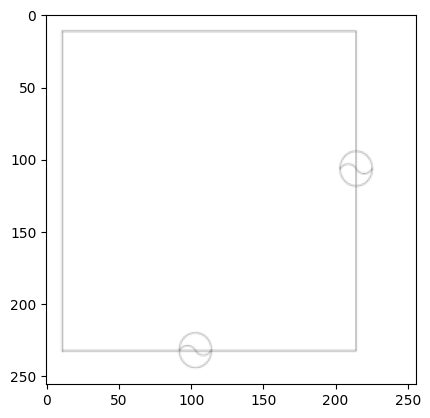

Label: ['19 0.767059 0.349428 0.896471 0.349428 0.896471 0.485388 0.767059 0.485388', '19 0.344706 0.855146 0.463529 0.855146 0.463529 0.964422 0.344706 0.964422']


In [347]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CircuitDiagramDataset(
    root='yolo_dataset/train', 
    transform=transform
)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)


# Print an example image and its label from the training data
train_features, train_labels = train_dataloader.dataset[4]

# Convert the first tensor image in the batch back to a PIL image
to_pil = transforms.ToPILImage()
img = to_pil(train_features)
label = train_labels
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# Defining Model

In [345]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=40):
    # Where we define all the parts of the model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
        
                                                                


In [346]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)